# 03 — Resultados E0: consolidación, deltas y plots

Este notebook lee los outputs de **E0** y genera:
- Tabla consolidada (global) por modelo y feature set
- Deltas vs baseline (FS0)
- Figuras (barras) para incluir en la memoria

Requiere haber ejecutado **02_run_E0_ablation_training.ipynb** (para crear `outputs/E0_ablation/summary_metrics.csv`).

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import pandas as pd

# Ensure PROJECT_ROOT is on sys.path so `import src.*` works reliably
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR
if (PROJECT_ROOT / 'src').exists() is False and (PROJECT_ROOT.parent / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.e0_ablation_utils import get_project_paths

paths = get_project_paths(project_root=PROJECT_ROOT, output_dir='outputs/E0_ablation')
OUTPUT_DIR = paths.output_dir

summary_path = OUTPUT_DIR / 'summary_metrics.csv'
print('OUTPUT_DIR:', OUTPUT_DIR)
print('summary_path:', summary_path, 'exists=', summary_path.exists())

OUTPUT_DIR: /mnt/custom-file-systems/s3/shared/TFMAXEL/outputs/E0_ablation
summary_path: /mnt/custom-file-systems/s3/shared/TFMAXEL/outputs/E0_ablation/summary_metrics.csv exists= True


In [2]:
if not summary_path.exists():
    raise FileNotFoundError(f'Missing {summary_path}. Run notebook 02 first.')

summary = pd.read_csv(summary_path)
display(summary)
print('rows:', len(summary))

,model,feature_set,val_fit_predict_sec,test_fit_predict_sec,MAE,RMSE,sMAPE
0,lstm_exog,FS0,2.341277,0.318473,710089.292938,7.581639e+05,64.518722
1,lstm_exog,FS1,0.139632,0.324879,729429.159086,7.577307e+05,66.809316
2,lstm_exog,FS2,0.148299,0.336044,722022.504484,7.552919e+05,66.000368
3,transformer_exog,FS0,0.307933,0.482765,920418.052308,1.088733e+06,118.051787
4,transformer_exog,FS1,0.184602,0.488274,893289.744446,1.069371e+06,111.388046
5,transformer_exog,FS2,0.193915,0.503371,611855.154668,6.413315e+05,58.701062


rows: 6


## Tabla pivot (métricas globales)
Pivot por modelo y feature set para inspección rápida.

In [3]:
metrics = ['MAE','RMSE','sMAPE']
pivot = summary.pivot_table(index='model', columns='feature_set', values=metrics)
display(pivot)

MAE                                        RMSE  \
feature_set                 FS0            FS1            FS2           FS0   
model                                                                         
lstm_exog         710089.292938  729429.159086  722022.504484  7.581639e+05   
transformer_exog  920418.052308  893289.744446  611855.154668  1.088733e+06   

                                                    sMAPE              \
feature_set                FS1            FS2         FS0         FS1   
model                                                                   
lstm_exog         7.577307e+05  755291.945290   64.518722   66.809316   
transformer_exog  1.069371e+06  641331.540073  118.051787  111.388046   

                             
feature_set             FS2  
model                        
lstm_exog         66.000368  
transformer_exog  58.701062

## Deltas vs FS0
Calculamos $\Delta$ por métrica y modelo, donde $\Delta = metric(FSx) - metric(FS0)$.
- Valores negativos en MAE/RMSE/sMAPE implican mejora.

In [4]:
base = summary[summary['feature_set'] == 'FS0'][['model'] + metrics].set_index('model')

deltas = summary.copy()
for m in metrics:
    deltas[m] = deltas.apply(lambda r: r[m] - base.loc[r['model'], m], axis=1)

deltas = deltas.sort_values(['model','feature_set']).reset_index(drop=True)
display(deltas)

delta_path = OUTPUT_DIR / 'summary_deltas_vs_FS0.csv'
deltas.to_csv(delta_path, index=False)
print('Saved:', delta_path)

,model,feature_set,val_fit_predict_sec,test_fit_predict_sec,MAE,RMSE,sMAPE
0,lstm_exog,FS0,2.341277,0.318473,0.000000,0.000000,0.000000
1,lstm_exog,FS1,0.139632,0.324879,19339.866148,-433.241784,2.290594
2,lstm_exog,FS2,0.148299,0.336044,11933.211546,-2871.963660,1.481646
3,transformer_exog,FS0,0.307933,0.482765,0.000000,0.000000,0.000000
4,transformer_exog,FS1,0.184602,0.488274,-27128.307862,-19362.003781,-6.663741
5,transformer_exog,FS2,0.193915,0.503371,-308562.897640,-447401.081262,-59.350725


Saved: /mnt/custom-file-systems/s3/shared/TFMAXEL/outputs/E0_ablation/summary_deltas_vs_FS0.csv


## Plots
Generamos gráficos de barras para cada métrica y los guardamos en `outputs/E0_ablation/figures/`.

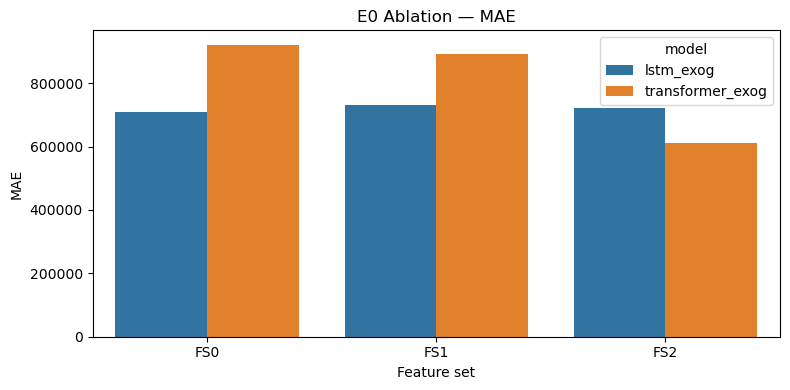

Saved: /mnt/custom-file-systems/s3/shared/TFMAXEL/outputs/E0_ablation/figures/e0_ablation_MAE.png


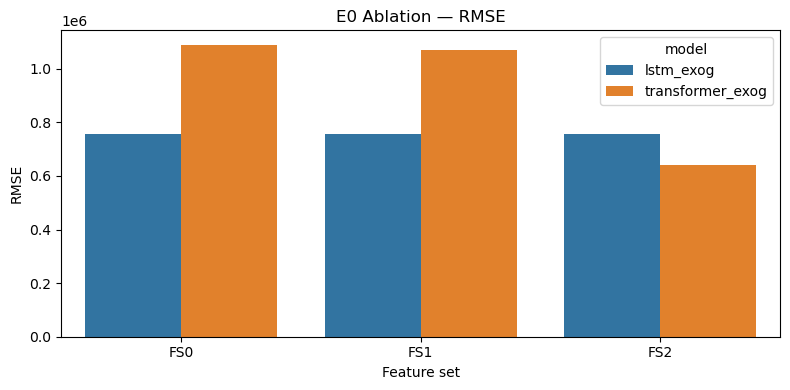

Saved: /mnt/custom-file-systems/s3/shared/TFMAXEL/outputs/E0_ablation/figures/e0_ablation_RMSE.png


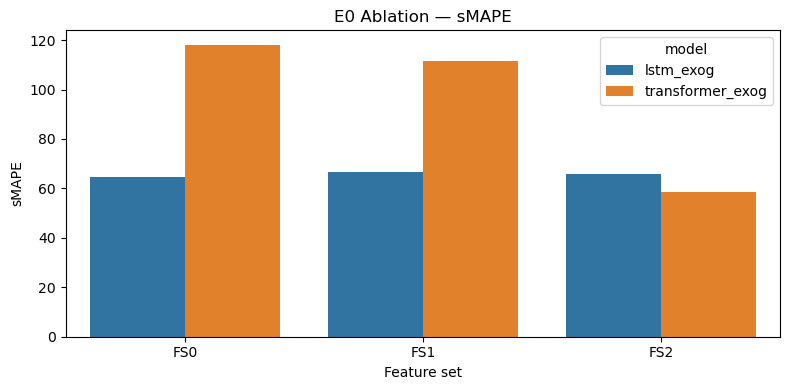

Saved: /mnt/custom-file-systems/s3/shared/TFMAXEL/outputs/E0_ablation/figures/e0_ablation_sMAPE.png


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_dir = OUTPUT_DIR / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

order_fs = ['FS0','FS1','FS2']

for m in metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=summary, x='feature_set', y=m, hue='model', order=order_fs)
    plt.title(f'E0 Ablation — {m}')
    plt.xlabel('Feature set')
    plt.ylabel(m)
    plt.tight_layout()
    out = fig_dir / f'e0_ablation_{m}.png'
    plt.savefig(out, dpi=160)
    plt.show()
    plt.close()
    print('Saved:', out)

## Export rápido para LaTeX (opcional)
Genera una tabla `.tex` con `pandas.to_latex()` basada en `summary_metrics.csv`.

Si prefieres una tabla con formato específico de la plantilla, usa `[COMPLETAR: ...]` y la adaptamos.

In [6]:
tex_dir = OUTPUT_DIR / 'tables'
tex_dir.mkdir(parents=True, exist_ok=True)

tbl = summary.sort_values(['model','feature_set'])[['model','feature_set'] + metrics]
tex_path = tex_dir / 'e0_ablation_summary.tex'
tex_path.write_text(tbl.to_latex(index=False, float_format='%.4f'), encoding='utf-8')
print('Saved:', tex_path)

Saved: /mnt/custom-file-systems/s3/shared/TFMAXEL/outputs/E0_ablation/tables/e0_ablation_summary.tex
